# ANÁLISE DE PRECONCEITO 
## por Letícia Tavares da Silva






># Motivação





>O discurso de ódio, usualmente estabelecido como qualquer discurso que apresente desprezo por uma ou mais pessoas com base em alguma carecterísica como cor, gênero, orientação sexual, aparência, religião, identidade de gênero ou outra, afeta milhões de pessoas em todo mundo tendo um maior impacto atualmente graças aos sites e redes sociais. Esse trabalho tem como propósito dar início a uma possível solução para identificação de indícios de preconceito em textos para que futuramente possa ser utilizado como ferramenta na luta para mudar essa situação, levando informações para as pessoas que praticam esse ato que talvez as faça mudar de atitude, diminuindo assim o bullying cibernético e possivelmente o pessoal.



># Definição do Problema

>O dataset utilizado é constituído por uma coluna denominada "frase" que contém 452 documentos, onde cada documento é uma frase com teor preconceituoso retirada da internet, e outra coluna que apresenta a classificação do preconceito contido em cada frase. Esse trabalho apresenta apenas quatro tipos de preconceito, sendo eles Sexismo, LGBTFobia, Racismo e Gordofobia. Para este método, a coluna tipo, ou seja, as categorias reais servirão apenas para ajudar a avaliar se os tópicos encontrados fazem sentido.

>Após a fase de pré-processamento do texto, uma matriz será montada com cada documento como uma linha e cada palavra como uma coluna. Os valores serão preenchidos pelo cálculo de frequência de cada palavra calculada pelo método "Frequência do Documento Inverso".

>Reconstruir a matriz usando um produto externo de dois vetores seria bastante complicado. Na maioria dos casos, não conseguimos reconstruir exatamente a matriz. Porém, se tivermos um vetor com a frequência relativa de cada palavra do vocabulário fora da contagem total de palavras, e um com o número médio de palavras por documento, então esse produto externo seria o mais próximo possível.

>## Tópicos

>Consideremos essas matrizes para duas colunas e duas linhas. A decomposição ideal seria agora agrupar os documentos em dois grupos, cada um dos quais tem uma distribuição de palavras tão diferente quanto possível, mas o mais semelhante possível entre os documentos no mesmo grupo. Vamos chamar esses dois grupos de "tópicos". E agruparíamos as palavras em dois grupos, com base naqueles que aparecem com mais frequência em cada um dos tópicos. O desafio nesse método é determinar o número de tópicos ideal.

>## Importando as funções

>Primeiro, é necessário importar as funções e classes que serão utilizadas, junto com a abreviação de funções no pacote numpy. Onde a classe CountVectorizer será usada para criar uma matriz de termo de documento.

In [ ]:
from time import time
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
import pandas as pd

>## Importando o Dataset

>Como citado anteriormente, este dataset é composto por duas colunas, frases e tipo, respectivamente. A categoria frase contém 452 frases retiradas da internet com teor preconceituoso, enquanto a categoria tipo contém o tipo de preconceito contido em cada frase. 

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print("Loading dataset...")
hate = pd.read_csv("https://raw.githubusercontent.com/leticiatavaresds/Projeto-ALA/master/teste.csv")
t0 = time()
dataset = hate
data_samples = dataset.frase[:452]
print("done in %0.3fs." % (time() - t0))


Loading dataset...
done in 0.001s.


>Abaixo é possível observar uma amostra com as primeiras 15 linhas do dataset para se ter uma ideia do que está sendo trabalhado.

In [ ]:
hate.head(15)

,frase,tipo
0,Mulher tem de se dar ao respeito,Sexismo
1,não sou preconceituoso tenho até um amigo negro,Racismo
2,pode ser gay mas não precisa beijar em público,LGBTfobia
3,mulher ao volante perigo constante,Sexismo
4,ela tem cabelo ruim,Racismo
5,isso é coisa de mulherzinha,Sexismo
6,ela é bonita mas é gordinha,Gordofobia
7,um bando de vagabundinha de vestido curto,Sexismo
8,gorda suja,Gordofobia
9,gritei vai macaca pela janela e a vizinha negr...,Racismo


>Para facilitar o entendimento sobre a base de dados, abaixo é possível visualizá-la em Dataframe, vendo as informações gerais dos dados.



In [ ]:
print('Tamanho da base de treinamento {}\n'.format(hate.shape[0]))
hate.tipo.value_counts()

Tamanho da base de treinamento 452



LGBTfobia     191
Sexismo       174
Racismo        60
Gordofobia     27
Name: tipo, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


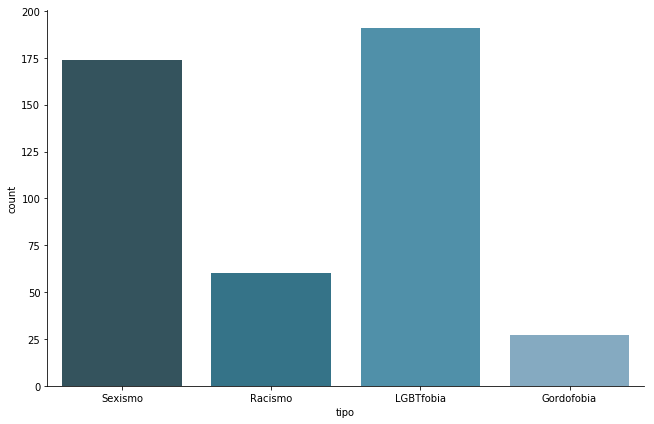

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.factorplot(x="tipo", data=hate, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [ ]:
print(hate.tipo.value_counts()/(hate.shape[0])*100)

LGBTfobia     42.256637
Sexismo       38.495575
Racismo       13.274336
Gordofobia     5.973451
Name: tipo, dtype: float64


>## Balanceamento das Classes

>É possível notar que o conjunto não está balanceado, com referência ao tipo. Se contarmos o número de documentos de cada etiqueta, podemos ver que há um número significativamente maior de frases rotuladas como Sexismo e LGBTfobia. De fato, apenas 5,9% são classificados como gordofobia e 13,2% como Racismo, quando o ideal seria proporções iguais, ou seja, cada um das quatro categorias com 25% . Isso é problemático, pois com esses dados, há uma grande chance de que ele seja padronizado para prever todos os rótulos como LGBTfobia ou Sexismo, o que afetará na eficiência do código.

>Uma forma de tentar contornar a situação é usar a função upsampling. Em que são recebidos e substituídos documentos da classe minoritária até que a classe esteja do mesmo tamanho que a maioritária. Com substituição significa que o mesmo documento pode ser usado várias vezes, ou seja, repetido. Como tem duas classes com muitas frases e duas com poucas, serão balanceado dois pares, sendo o primeira LGBTfobia e Gordofobia, e logo após, Sexismo e Racismo.



In [ ]:
from sklearn.utils import resample
train_majority = hate[hate.tipo=='LGBTfobia']
train_minority = hate[hate.tipo=='Gordofobia']
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
balance1 = pd.concat([train_minority_upsampled, train_majority])
balance1['tipo'].value_counts()

Gordofobia    191
LGBTfobia     191
Name: tipo, dtype: int64

In [ ]:
from sklearn.utils import resample
train_majority = hate[hate.tipo=='Sexismo']
train_minority = hate[hate.tipo=='Racismo']
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
balance2 = pd.concat([train_minority_upsampled, train_majority])
balance2['tipo'].value_counts()

Sexismo    174
Racismo    174
Name: tipo, dtype: int64

In [ ]:
hate = pd.concat([balance1, balance2])

In [ ]:
print('Tamanho da base de treinamento {}\n'.format(hate.shape[0]))
hate.tipo.value_counts()

Tamanho da base de treinamento 730



Gordofobia    191
LGBTfobia     191
Sexismo       174
Racismo       174
Name: tipo, dtype: int64

>No gráfico abaixo é possível notar como as classes ficaram mais balanceadas, apesar de melhorar a situação para o código, não é ideal já que frases repetidas não acrescentam informações novas.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


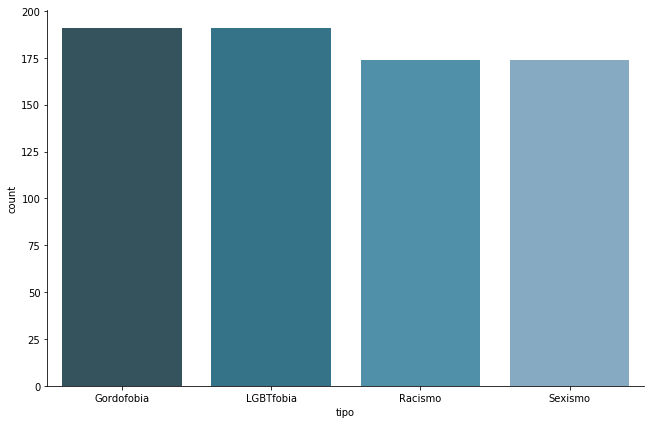

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.factorplot(x="tipo", data=hate, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

>## Tokenização

>Cada palavra em uma frase tem um peso, ou seja, não se deve olhar uma frase como um todo, mas cada palavra que compõem esta frase. Logo, o Python precisa pegar cada frase e a separar. Representando assim cada documento de texto como o conjunto de suas palavras. Essa representação é conhecida como Bag-of-Words, em que geramos os atributos do texto como atributos categóricos. E esse processo é conhecido como tokenização lexical que marca cada palavra como um token no texto, identificando-a mesmo se tiver encostada em alguma pontuação. Dessa forma, a função quebra cada texto em palavras, criando desse modo um array com todas as palavras contidas dentro do texto. 
Por exemplo, como é possível observar a baixo, a frase "nos só realizamos exames até tal peso" foi transformada no array ['nos', 'so', 'realizamos', 'exames', 'ate', 'tal', 'peso'].


In [ ]:
import gensim

data = hate.frase.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(data))

print(data_words[:3])

[['nos', 'so', 'realizamos', 'exames', 'ate', 'tal', 'peso'], ['ta', 'gorda', 'demais'], ['ta', 'gorda', 'demais']]


>## Stop-Words

>Ainda trabalhando no texto, é necessário remover as "stopwords" que são palavras muito frequentes, tais como “a”, “de”, “o”, “da”, “que”, “e”, “do” entre outras. São palavras que podem ser consideradas irrelevantes para o entedimento do sentido de um texto, ou seja, palavras semanticamente irrelavantes normalmente advérbios, artigos, pronomes e preposições. No array abaixo é possível ver as palavras removidas.


In [ ]:
import nltk
import numpy as np

nltk.download('stopwords')
nltk.download('rslp')
lista_Stop = nltk.corpus.stopwords.words('portuguese')
np.transpose(lista_Stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


array(['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com',
       'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos',
       'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou',
       'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo',
       'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo',
       'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa',
       'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos',
       'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas',
       'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus',
       'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos',
       'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele',
       'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está',
       'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram',
       'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos',
  

>## Stemming 

>É uma técnica que permite diminuirmos a palavra até a sua raiz/radical. Assim são eliminados prefixos, sufixos, características de número, gênero e grau. Desta forma, diversas palavras são reduzidas para um mesmo termo e tratadas como uma só. Para exemplificar, as palavras mulher e mulheres quando submetidas à função de Stemming, ambas as palavras serão diminuídas até a base "mulh".





In [ ]:
import spacy
def aplica_Stemmer(texto):
  stemmer = nltk.stem.RSLPStemmer()
  frases_sem_Stemming = []
  for(palavras) in texto:
    com_Stemming = [str(stemmer.stem(p)) for p in palavras if p not in lista_Stop]
    frases_sem_Stemming.append(" ".join(com_Stemming))
    
  return frases_sem_Stemming

In [ ]:
data_words = aplica_Stemmer(data_words)

>## Gráfico de Frequências das Palavras

>O gráfico abaixo apresenta a frequência das vinte palavras que mais aparecem em analisando todas os documentos. Pode-se se observar que as mais aparecem são as raízes nao,você, gord, mulh e ser. Talvez para outros propósitos as palavras "nao" e "ser" fossem desnecessárias, porém para esse trabalho, elas possuem pesos importantes, a palavra "não" por exemplo é bastante frequente em frases sexistas.

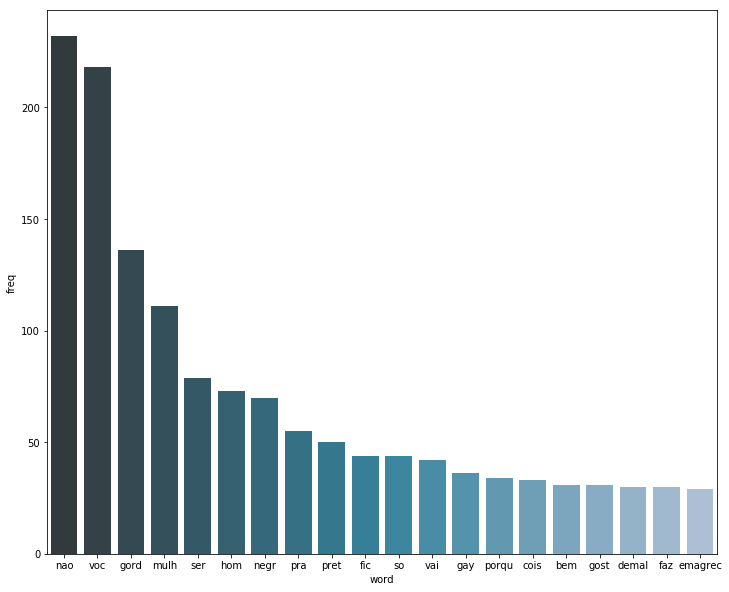

In [ ]:
import collections
cv = CountVectorizer()
bow = cv.fit_transform(data_words)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

>## Transformação Tfidf

>O algoritmo do modelo NMF requer uma matriz de documento por palavra como a entrada principal. Então, vou vetorizar meus dados usando transformação TfidfVectorizer, que irá contar as ocorrências de cada palavra, em cada documento, resultando em uma matriz de termos-freqüências de Dimensões: quantidade de documentos  por quantidade de palavras, onde a ordem das palavras não importa.

>Nem todas as palavras presentes em um docmento possuem a mesma importância. Em qualquer documento de texto, haverá várias palavras que aparecem com muita frequência e que nem sempre são significantes para a classificação. Se fôssemos construir um modelo sem pesar essas palavras, elas ofuscariam palavras menos frequentes durante o treinamento. Ao ponderarmos estas palavras de alta frequência, podemos atribuir, por exemplo, mais importância a palavras menos frequentes, mas talvez mais úteis.

>Há várias fórmulas para calcular a importância ou peso da palavra no documento, porém aqui será utilizado o método TFIDF.

>### Frequência Absoluta (TF)

>$TF(w) = \frac{F(w) }{F(Todas as palavras)}$

>onde $F(w)$ é a frequência de um termo $w$ em um documento. 

>A matriz de termos-freqüências (TF) atribui uma pontuação a uma palavra com base em sua ocorrência em um documento específico . Isso é ruim pois palavras mais comuns (artigos, preposições, etc) deveriam ter peso menor, já que são menos discriminantes, para isso foram ignoradas palavras comuns como artigos e preposições usando (stopwords). Porém, pode haver palavras comum para a situação, mas que não está dentro da lista de palavras do stopwords. O TFIDF resolve esse problema.

>### Frequência Inversa de Documentos (IDF)

>$IDF(w) = log\frac{N}{dF_t}$,

>onde $N$ é a quantidade de documentos e $dF_t$ é a quantidade de documentos em que o termo $w$ aparece.

>A fórmla do IDF é capaz de aumentar a importância de palavras que aparecem um poucos documentos e diminuir a importância de palavras que aparecem em muitos, já que termos de baixa frequencia são normalmente mais discriminantes.



>Assim o peso de cada termo (t): 
*   aumenta quando t aparece muitas vezes em poucos documentos 
*   diminui quando t aparece em muitos documentos 
*   diminui quando t aparece poucas vezes no documento


>### Construtor de Classe

>Existem alguns parâmetros importantes que devem ser passados para o construtor da classe. O primeiro parâmetro é o max_features. Isso ocorre porque, quando convertemos palavras em números usando a abordagem do pacote de palavras, todas as palavras únicas em todos os documentos são convertidas em recursos. Todos os documentos podem conter dezenas de milhares de palavras únicas. Mas as palavras que têm uma freqüência muito baixa de ocorrência são raramente um bom parâmetro para classificar documentos. Assim, ao atribuir um número inteiro $n$ ao  max_features, apenas as $n$ palavras que mais ocorrem como recursos serão consideradas.Como o dataset aqui utilizado é pequeno e restaram poucos recursos após o processameto do texto, o max_features não é necessário e não entrará no construtor.

>O próximo parâmetro é min_df que foi definido como 5. Isso corresponde ao número mínimo de documentos que devem conter esse recurso. Desta forma, apenas as palavras que ocorrem em pelo menos 5 documentos serão inclusas. Da mesma forma, para o max_df, o valor é definido como 0,85, em que a fração corresponde a uma porcentagem. Aqui 0.85 significa que será incluiso apenas as palavras que ocorrem em no máximo 85% de todos os documentos. Palavras que ocorrem em quase todos os documentos geralmente não são adequadas para classificação porque não fornecem informações exclusivas sobre cada um.

>Finalmente, as palavras de parada (stop words) serão removidas do texto, pois, no caso da análise de sentimento, as palavras de parada não podem conter nenhuma informação útil.




d_{\mathrm{Fro}}(X, Y) = \frac{1}{2} ||X - Y||_{\mathrm{Fro}}^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - {Y}_{ij})^2

In [ ]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5,
                                   stop_words= lista_Stop)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_words)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.015s.


># NMF - Fatoração de Matriz Não-Negativa

>A NMF (fatoração de matriz não-negativa) é um método de fatoração de matriz em que as matrizes são restringidas a serem não-negativas. Nessa redução dimensional a matriz inicial $V$ é decomposta em duas matrizes $W$ e $H$, sendo que as três matrizes são não-negativas, ou seja, possuem todos os seus valores nulos ou positivos.  


>No NMF a matriz original $V (m$ x $n)$ onde $m$ é o número de documentos e $n$ o número de palavras, é aproximadamente fatorizado em uma matriz  $D = WH$, onde $W (m$ x $k)$ é a matriz de pesos , $H  (k$ x $n)$ é a matriz de características e $k$ é um parâmetro definido. Nessa aplicação, $k$ será o número de agrupamentos e está associado ao número de tópicos a serem encontrados nas frases.  Geralmente k é escolhido para ser menor que $n$ ou $m$, de modo que $W$ e $H$ sejam menores que a matriz original D. Isso resulta em uma versão compactada da matriz de dados original.

>## NMF - Modelagem de tópicos

>![alt text](https://camo.githubusercontent.com/d79bd34554928909c53bc691c2567b97484ae2ad/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f662f66392f4e4d462e706e672f34303070782d4e4d462e706e67)

>Uma matriz documento-termo, como a que foi montada anteriormente, pode ser decomposta em componentes que podem ser considerados “tópicos” e cada documento pode ser decomposto em uma média ponderada de tópicos. Devido a isso, essa decomposição é a que melhor se aplica a esse trabalho já que a não-negatividade torna a interpretacão destas matrizes mais simples. Não seria possível ter uma interpretação lógica do que significa um tópico ter peso “negativo”. Apenas zero que implica o tópico não está relacionado ao documento, ou um valor positivo que indica seu peso no mesmo. 

>Embora existam algumas variantes, uma medida existente que será usada é a norma Frobenius (a soma dos erros quadrados por elementos). 

>$||a||_F = tr(a^T,a)^(\frac{1}{2})$

>Onde $tr(x,y)$ representa o produto interno entre $x$ e $y$.

>## NMF - Aplicando o Algoritmo 


>No Python , o NMF é implementado a classe decomposition.NMF da biblioteca de aprendizagem de máquina chamada “Scikit-Learn”. Essa classe utiliza como método de otimização o método  MU (Multiplicative Update).


>Neste método, o $W$ e o $H$,  cada um deles é atualizado iterativamente de acordo com a seguinte regra que garante que uma vez tendo-se matrizes não-negativas, a atualização garante a preservação da não-negatividade:

>O processo iterativo consiste em alternadamente realizar o método de gradiente descendente para a matriz $W$ e $H$:
 
>$W ← W − ηW∇wf$

>$H ← H − ηH∇Hf$

>sendo $ηχ$ uma matriz contendo os passos a serem escolhidos e $∇χf$ o gradiente.

>e assim, calcular seu gradiente em relação a $W$ torna-se mais fácil:

>$∇Wf = WHH^T − VH^T$

>Analogamente, em relação a $H$:

>$∇Hf = W^TWH − W^TV$

>Substituindo as Equaçõe, as respectivas regras de atualização são dadas por

>$W ← W − ηW(WHH^T − VH^T)$

>$H ← H − ηH(W^TWH − W^TV$

>Adotando:

>$ηW = \frac{W}{WHH ^ T}$

>e 

>$ηW = \frac{H}{W^ TWH}$

>A descida de gradiente escalada pode ser escrita da seguinte forma:

>$W ←  [W]_{i,j}    [\frac{VH^ T}{WHH ^ T}]_{i,j} $ 

>$H ←  [H]_{i,j}     [\frac{W^ TV}{W^ TWH}]_{i,j} $ 

>Essa é a regra de atualização multiplicativa utilizada para obter as matrizes $W$ e $H$.



In [ ]:
vectors_tfidf = tfidf_vectorizer.fit_transform(data_words)
V = tfidf_vectorizer.fit_transform(data_words).toarray()
vocab = np.array(tfidf_vectorizer.get_feature_names())

>## Tamanho do Vocabulário

>Apos o processo de Stemming e retirada das Stop Words sobraram apenas 203 palavras no vocabulário, o que é um número bem pequeno para um bom resultado.

In [ ]:
len(vocab)

203

>## Tamanho da Matriz

>A matriz que foi montada com o dataset após todos o processamento de texto, possui 730 linhas, ou seja, 730 documentos e 203 colunas em que cada uma representa uma palavra do vocabulário presente no dataset.

In [ ]:
V.shape

(730, 203)

In [ ]:
from sklearn import decomposition

num_topics = 6
num_top_words = 10

clf = decomposition.NMF(n_components=num_topics, random_state=1)

>## Decomposição da Matriz

>Implementado a classe decomposition.NMF da biblioteca “Scikit-Learn”.O método de otmização MU (Multiplicative Update) anteriormente será aplicado, e assim serão obtidas as duas matrizes $W$, de tamanho $(730, 6)$ e $H$, de tamnho $(6, 203)$.

In [ ]:
W = clf.fit_transform(vectors_tfidf)
H = clf.components_

In [ ]:
W.shape

(730, 6)

In [ ]:
H.shape

(6, 203)

>## Matriz W

>Cada elemento  $a_{ij}$ da matriz $W$ representa a importância de cada tópico $j$ sobre o o documento $i$. 


>## Matriz H

>Cada elemento  $a_{ij}$ da matriz $H$ representa o peso da palavra $j$ sobre o tópico $i$. Abaixo, é possivel observar pelo primeiro array da matriz $H$, o peso de cada uma das $203$ Palavras sobre o Tópico $0$.

In [ ]:
H[0:1]

array([[9.54957250e-03, 1.67417086e-01, 0.00000000e+00, 2.41559344e-02,
        0.00000000e+00, 9.92716728e-03, 0.00000000e+00, 4.29351233e-02,
        1.20963035e-02, 0.00000000e+00, 0.00000000e+00, 2.51667159e-02,
        1.49903627e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.91017207e-02, 0.00000000e+00, 1.36000450e-04, 6.47090070e-02,
        7.99964455e-04, 4.55128738e-02, 3.21448561e-02, 0.00000000e+00,
        4.44963501e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.12387357e-02, 6.53094919e-02, 5.05289779e-02, 4.55128738e-02,
        0.00000000e+00, 3.61160742e-02, 9.15190395e-03, 9.38395248e-03,
        2.21265885e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.30151319e-02, 0.00000000e+00, 0.00000000e+00,
        3.59232258e-03, 0.00000000e+00, 0.00000000e+00, 1.78320255e-02,
        5.23836869e-02, 4.02936022e-02, 1.73071497e-02, 0.00000000e+00,
        0.00000000e+00, 4.76311178e-02, 1.32648750e-02, 5.669963

In [ ]:

doctopic = clf.fit_transform(V)

In [ ]:
topic_words = []

for topic in clf.components_:
   word_idx = np.argsort(topic)[::-1][0:num_top_words]
   topic_words.append([vocab[i] for i in word_idx])

In [ ]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
frases = []

for fn in hate.frase:
   basename = os.path.basename(fn)
   name, ext = os.path.splitext(basename)
   name = name.rstrip('0123456789')
   frases.append(name)
   

frases = np.asarray(frases)

doctopic_orig = doctopic.copy()


num_groups = len(set(frases))

doctopic_grouped = np.zeros((num_groups, num_topics))

for i, name in enumerate(sorted(set(frases))):
   doctopic_grouped[i, :] = np.mean(doctopic[frases == name, :], axis=0)
    

doctopic = doctopic_grouped

>Pelo array abaixo pode ser visto o peso de cada tópico sobre o primeiro documento, se ele fosse classificado apenas em um tópico, seria no tópico 4 que possui maior peso.

In [ ]:
doctopic[0]

array([0.        , 0.04014027, 0.11876195, 0.03487505, 0.60965322,
       0.19656952])

>No código abaixo, pode-se observar os três tópicos com mais peso em cada frase, nota-se que as frases não estão mais na ordem que se encontravam no dataset, mas sim em ordem alfabética.

In [ ]:
frase = sorted(set(frases))

print("Top NMF topics in...")
  
for i in range(len(doctopic)):
   top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
   top_topics_str = ' '.join(str(t) for t in top_topics)
   print("{}: {}".format(frase[i], top_topics_str))

Top NMF topics in...
 A única coisa que você pilota bem é fogão: 4 5 2
 Mulher age com emoção e não com a razão: 1 0 5
 Mulher não sabe jogar futebol: 1 0 5
90% dos adotados vão ser homossexuais e vão ser garotos de programa deste casal: 5 3 4
A coisa tá preta: 2 5 1
A mas também ela pediu né andando com um cara desses!: 5 2 1
A mulher nasceu para ser mãe: 5 1 4
A mulher que usa roupas provocativas não pode reclamar se for estuprada: 1 0 3
A mulher é mais sensível por isso é suscetível ao pecado  eles custam a acreditar mas quem manda mesmo é o homem: 1 0 5
A noite aquela avenida fica cheia de travecos se oferecendo para programa: 4 5 1
A única coisa que mulher sabe pilotar bem é o fogão: 1 5 2
ABSURDO!!!!! Deus fez o homem para a mulher e a mulher para o homem! Fim de papo: 1 0 5
Abusar de mulher feia é fazer um favor: 1 5 4
Achei foi pouco. Tinha que dar uns tapas no resto das aberrações que estão nessa modinha ai: 4 0 1
Adoro gay mas não gosto que fiquem se beijando na minha frente:

># Resultado

>Finalmente, é possivel visualizar as palavras de maior peso que caracterizam cada tópico. Como a matriz possui 203 colunas, o seja, cada tópico tem o peso de todas as palavras, o número de palavras que serão usadas para caracterizar é escolhido manualmente, aqui foi estipulado como 10, assim aparecem apenas a 10 top words de cada tópico. Este é o resultado final do projeto, com base na análise das palavras mais importantes de cada tópico é que se deve classificá-lo, mas como o dataset utilizado é pequeno e vocabulário ficou com poucas palavras, o resultado obtido não ficou satisfatório, sendo complicado a classificar cada tópico. 
Um dos que daria pra classificar seria o tópico 1. Como as palavras de mais importância dele são "mulher", "homem", "gosta/gostosa", "fetiche", "feia", "sabe/saber", pode ser classificado como Sexismo.

>Se o resultado obtido fosse satisfatório, assim seria feita a análise. Cada tópido receberia uma das quatro classificações de acordo com suas 10 palavras mais importantes.

In [ ]:
for t in range (len(topic_words)):
  print("Tópico {}: {}".format(t, ' '.join(topic_words[t][:15])))

Tópico 0: nao tamanh gay roup trabalh hom pod gost ach estupr
Tópico 1: mulh hom gost fetich ter cois fei assim sab filh
Tópico 2: gord suj ta demal cois marx bonit fetich barrig umbig
Tópico 3: negr amig ate sex lug suj alm list bonit verdad
Tópico 4: voc bonit fic porqu nunc emagrec pra ach pens lind
Tópico 5: ser gay tud bem pra cheir chat legal dev precis


># Conclusão

>Nesta projeto foi apresentado a construção de um método de classificação de preconceito em textos aplicado em frases retiradas da internet em português brasileiro, onde todas possuiam discurso de ódio.

>Na proposta foi utilizada uma metodologia para a análise do preconceito com base no aprendizado de máquina que envolvia o método de Fatorização de Matriz Não-Negativa. Para isso, foram realizadas as etapas de coleta de frase com teor preconceituoso, rotulação manual de cada frase, pré-processamento dos dados, construção de uma matriz com os dados, fatorização da matriz e análise do resultado.

>O resultado obtido não foi satisfatório devido a baixa qualidade do dataset que além de possuir poucos documentos, não está balanceado e possue muitas frases parecidas, contendo assim um vocablário pequeno. Além disso, o tema escolhido possuem mensagens difíceis de serem rotuladas até mesmo pelos humanos, com isso as incertezas nas classificações também podem ser justificadas por essa qestão. Dessa forma, fica visível a dificuldade deste tipo de classificação já que envolve conceitos de opinião e pontos de vista.



># Trabalhos Futuros

>A partir dos resultados obtidos, nota-se que alguns pontos merecem
atenção especial, como construir um dataset melhor e testar outros métodos para verificar se é possível obter um resultado com uma qualidade melhor.

>Podem ser feitas também análises específicas sobre os termos mais comumente utilizados por usuários do Twitter para abordar um tipo de preconceito poderiam ser realizadas. Além disso, utilizar a geolocalização para identificar regiões que mais comentam sobre tais assuntos identificando a polaridade das mensagens. 

>Com isso,  pretende-se dar continuidade a este projeto nas seguintes direções:


*  Obter um dataset maior e mais balanceado a partir de uma API fornecida pla rede social "twitter".
*  Procurar bibliotecas mais eficientes para o pré-processamento de textos em português brasileiro, se necessário, tentar construir uma ou trabalhar com documentos em inglês, já que para esse idioma é possível encontrar bibliotecas com boa qualidade.
* Calcular a acurácia do resultado
* Aplicar outros métodos como o LDA, para comparar os resultados obtidos e assim definir o melhor.
* Incluir informacões geográficas – como latitude e longitude dos emissores dos tweets, permitindo a geracão de grafos associados e o estudo da difusão dos tipos de preconceito;
*Criar uma função para analisar novos documentos de textos e classificá-los.




># Referências

>Topic modeling in Python - https://liferay.de.dariah.eu/tatom/topic_model_python.html
Mineiração de Dados - http://thiagomarzagao.com/assets/teaching/mineracao/slides10.pdf

>A Practical Introduction to NMF (nonnegative matrix factorization) - http://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/

>Uma Abordagem Computacionnal para Identificação de Indício de Preconceito em Textos baseado em Análise de Sentimentos. - http://www.repositorio.ufal.br/bitstream/riufal/2465/1/Uma%20abordagem%20computacional%20para%20identifica%C3%A7%C3%A3o%20de%20ind%C3%ADcio%20de%20preconceito%20em%20textos%20baseada%20em%20an%C3%A1lise%20de%20sentimentos.pdf

>NMF with the Frobenius norm - https://scikit-learn.org/stable/modules/decomposition.html#nmf-with-the-frobenius-norm

> Sklearn.decomposition.NMF - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

>Identificação de Temas em Redes Sociais por meio de técnicas 
de agrupamento - https://siaiap32.univali.br/seer/index.php/acotb/article/view/10562/5917

>Análise de Sentimento de Mensagens do Twitter em Português Brasileiro Relacionadas a Temas de Saúde - http://repositorio.unifesp.br/bitstream/handle/11600/41280/Disserta%E7%E3o%20-%20Gabriela%20Denise%20de%20Araujo.pdf;jsessionid=7CCB48A2713A5EDC4A5CAD91FA308B09?sequence=1

>Análise dos sentimentos expressos na rede social Twitter em relação aos filmes indicados
ao Oscar 2017 - https://repositorio.ufu.br/bitstream/123456789/20133/1/AnaliseSentimentosExpressos.pdf

>Topic Modeling with NMF and SVD - https://github.com/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb

>Non-Negative Matrix Factorization - https://github.com/lvazic/StockTradingInsights

